In [1]:
from dataset import SimulationDataset

data_dir = "../nuclear-fusion/data/preprocessed/"

simulationdataset = SimulationDataset(data_dir)

In [2]:
len(simulationdataset)

288

In [3]:
output, forcing = simulationdataset[0]

(491, 500, 2)
(491, 500)


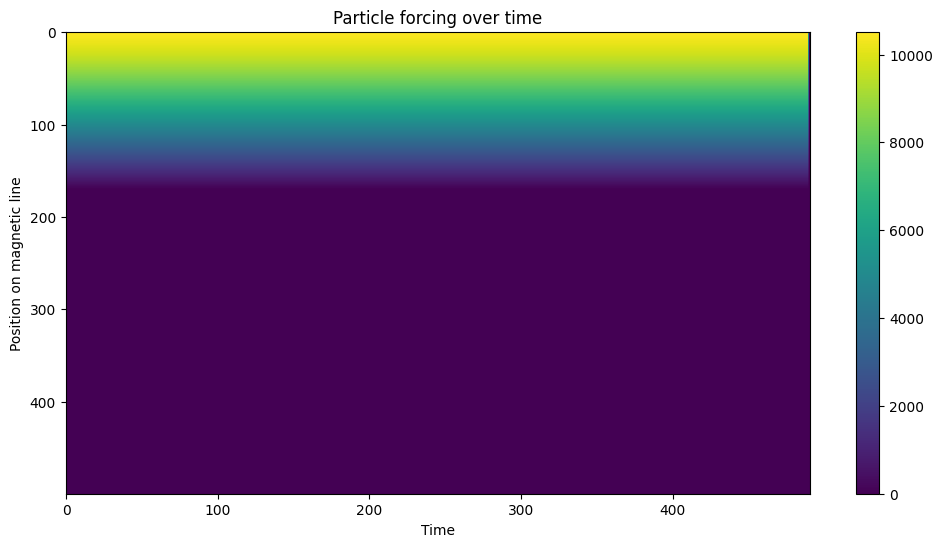

In [4]:
from utils import plot_1d_statistic_over_time
plot_1d_statistic_over_time(forcing, 0, "Particle forcing over time")

In [4]:
forcing.shape

(491, 500, 2)

In [5]:
simulationdataset.timesteps

[500, 1000, 100]

In [6]:
simulationdataset.ramp_directions

['ramp_down', 'ramp_up']